In [1]:
import numpy as np
import h5py

### We load the data from our dataset created in the notebook 'DataProcessing'.

In [2]:
with h5py.File('/kaggle/input/thebest/landmarks_array.h5', 'r') as f:
    X_data = f['landmarks_array'][:]

In [3]:
with h5py.File('/kaggle/input/thebest/y_data.h5', 'r') as f:
    y_data = f['y_data'][:]

In [4]:
y_data = y_data.reshape((575*30,))

**We divide each sequence into smaller sequences to identify each letter in a sentence. Each sentence consists of 30 characters.**

In [5]:
X_data_divided = []

for i in range(len(X_data)):
    video = X_data[i]
    for j in range(0, 720, 24):
        subvideo = video[j:j+24]
        X_data_divided.append(subvideo)
 
X_data = np.array(X_data_divided)

### Training data and Validation data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.15, random_state=1)

### Data Normalization

In [8]:
mean = np.mean(X_data, axis=0)
std = np.std(X_data, axis=0)

In [9]:
X_data = (X_data - mean) / (std+0.00001)
X_val = (X_val - mean) / (std+0.00001)

### Build and Train LSTM Neural Network


In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

In [26]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(24,84)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(59, activation='softmax'))
#model = Sequential()
#model.add(LSTM(units=128, input_shape=(24, 84)))
#model.add(Dense(units=59, activation='softmax'))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24, 128)           109056    
                                                                 
 lstm_7 (LSTM)               (None, 24, 128)           131584    
                                                                 
 lstm_8 (LSTM)               (None, 24, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 24, 128)           131584    
                                                                 
 lstm_10 (LSTM)              (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 59)               

In [28]:
checkpoint = ModelCheckpoint('ASL_model.hdf5',monitor='categorical_crossentropy', verbose= 1, save_best_only=True)

In [29]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [30]:
hist = model.fit(X_data, y_data, epochs=10, batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[checkpoint])

Epoch 1/10
540/540 [==============================] - 17s 17ms/step - loss: 3.3248 - categorical_accuracy: 0.5526 - val_loss: 3.2972 - val_categorical_accuracy: 0.5247
Epoch 2/10
540/540 [==============================] - 7s 14ms/step - loss: 3.2892 - categorical_accuracy: 0.5223 - val_loss: 3.3013 - val_categorical_accuracy: 0.5321
Epoch 3/10
540/540 [==============================] - 8s 15ms/step - loss: 3.2866 - categorical_accuracy: 0.5232 - val_loss: 3.2921 - val_categorical_accuracy: 0.5158
Epoch 4/10
540/540 [==============================] - 8s 14ms/step - loss: 3.2823 - categorical_accuracy: 0.5185 - val_loss: 3.2929 - val_categorical_accuracy: 0.5155
Epoch 5/10
540/540 [==============================] - 7s 14ms/step - loss: 3.2816 - categorical_accuracy: 0.5181 - val_loss: 3.2944 - val_categorical_accuracy: 0.5155
Epoch 6/10
540/540 [==============================] - 8s 14ms/step - loss: 3.2799 - categorical_accuracy: 0.5180 - val_loss: 3.2850 - val_categorical_accuracy: 0.51

**We can observe that we have a categorical_accuracy of only 50% for both the training and validation data. We will continue exploring the causes of this result in order to improve it in the future.**

In [31]:
import matplotlib.pyplot as plt

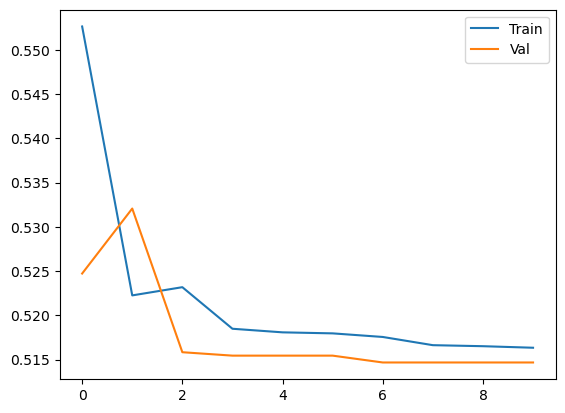

In [32]:
plt.plot(hist.history['categorical_accuracy'], label = 'Train')
plt.plot(hist.history['val_categorical_accuracy'], label = 'Val')
plt.legend()
plt.show()

**In the graph, we can see a clear case of overfitting.**

### Make Predictions

**As we explained, our model aims to interpret and translate each letter of a sign language sentence into English. In the y_val array, we have our list of characters, where every 30 characters form a sentence. In the y_pred array, we have the predicted values from our model, which returns an array of shape (2588, 59) representing the number of characters we have in both y_val and y_pred, as well as the number of classes. Let's observe that 30 of these characters match.**

In [33]:
y_pred = model.predict(X_val)

81/81 [==============================] - 2s 6ms/step


In [42]:
y_pred.shape

(2588, 59)

In [43]:
y_val.shape

(2588,)

In [44]:
phrase = []
for i in range(30):
    phrase.append(np.argmax(y_pred[i]))

In [47]:
np.array(phrase)

array([ 0,  0, 54,  0,  0, 32,  0, 54,  0,  0,  0, 54, 54,  0,  0,  0, 32,
       54,  0, 32, 54, 54, 36,  0, 54, 54, 54,  0, 54,  0])

In [46]:
y_val[:30]

array([ 0, 49, 39, 36,  0, 49, 38, 36, 45,  0, 49, 51, 14, 36,  0, 34, 32,
       43, 36, 42, 48, 52, 16, 44, 36, 18, 24,  0, 19, 43], dtype=int16)

**As expected, the difference between each array is significant, indicating that the model, and perhaps the approach we are taking, needs to be changed or improved.**

